In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [5]:
class Euler_Maruyama_Simulator:
    def __init__(
            self, funcs,
            y_init = 0, grid_points = 1000,
            t_init = 0, t_end = 10
        ):
        self.a = funcs[0]
        self.b = funcs[1]
        
        self.t_init = t_init
        self.t_end = t_end
        self.y_init = y_init
        self.N = grid_points
        self.dt = float(t_end - t_init) / self.N
        
        self.ts = np.arange(t_init, t_end + self.dt, self.dt)
        
    def dW(delta_t):
        return np.random.normal(scale=np.sqrt(delta_t))
    
    def simulate(self):
        ys = np.zeros(self.ts.size)
        ys[0] = self.y_init
        
        t = self.t_init
        dt = self.dt
        for i in range(1, self.ts.size):
            t = t + dt
            y = ys[i-1]
            ys[i] = y + \
                    self.a(y, t) * dt + \
                    self.b(y, t) * Euler_Maruyama_Simulator.dW(dt)
        return ys
    
    def get_ts(self):
        return copy.copy(self.ts)

In [6]:
def simulations_viewer(num_sims, simulator, show_log=False):    
    ts = simulator.get_ts()
    for _ in range(num_sims):
        ys = simulator.simulate()
        plt.plot(ts, ys)

    plt.xlabel("time (s)")
    if show_log:
        plt.yscale('log')
        
    h = plt.ylabel("y")
    h.set_rotation(0)
    plt.show()

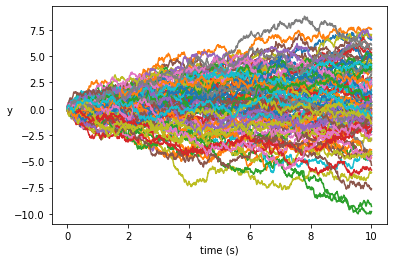

In [7]:
def Brownian_funcs():
    def a(y, t):
        return 0
    def b(y, t):
        return 1
    
    return a, b
    
em_brownian = Euler_Maruyama_Simulator(Brownian_funcs())
simulations_viewer(100, em_brownian)

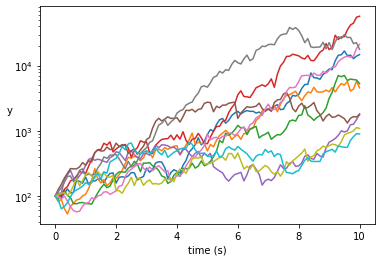

In [8]:
def Geometric_Brownian_funcs(mu, sigma):
    def a(y, t):
        return mu * y
    def b(y, t):
        return sigma * y
    
    return a, b

em_geometirc_brownian = Euler_Maruyama_Simulator(
        Geometric_Brownian_funcs(0.5, 0.5), 
        y_init=100, t_end = 10, grid_points=100
    )
simulations_viewer(10, em_geometirc_brownian, show_log=True)

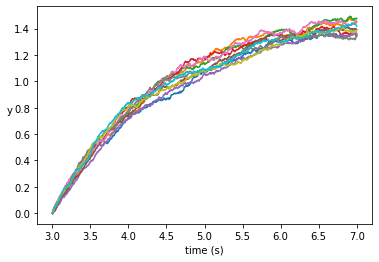

In [9]:
def Ornstein_Uhlenbeck_funcs(theta, mu, sigma):
    def a(y, t):
        return theta * (mu - y)
    def b(y, t):
        return sigma
    
    return a, b

ornstein_unlenbeck_process = Euler_Maruyama_Simulator(
        Ornstein_Uhlenbeck_funcs(0.7, 1.5, 0.06),
        t_init = 3, t_end = 7, y_init = 0,
        grid_points = 1000
    )
simulations_viewer(10, ornstein_unlenbeck_process)

In [10]:
class Fractional_Gaussian_Simulator:
    def __init__(self, H):
        self.h = H
        self.rho = [1]
        
    def __generate_rho_till(self, n):
        H = 2 * self.h
        for i in range(len(self.rho), n):
            self.rho.append(
                ((i+1)**H + (i-1)**H - 2*(i**H)) / 2
            )
    
    def simulate(self, n):
        cov = np.ndarray((n, n))
        self.__generate_rho_till(n)
        for ind, r in enumerate(self.rho):
            np.fill_diagonal(cov[ind:], r)
            np.fill_diagonal(cov[:, ind:], r)
            
        result = np.random.multivariate_normal(np.zeros(n), cov, 
                    check_valid='ignore')
        return result
    
class Fractional_Brownian_Simulator:
    def __init__(
            self, H, 
            y_init = 0, grid_points = 1000,
            t_init = 0, t_end = 10
        ):
        self.h = H
        
        self.t_init = t_init
        self.t_end = t_end
        self.y_init = y_init
        self.N = grid_points
        self.dt = float(t_end - t_init) / self.N
        self.factor = ((t_end - t_init) / self.N) ** H
        
        self.ts = np.arange(t_init, t_end + self.dt, self.dt)
        self.fGn = Fractional_Gaussian_Simulator(H)
    
    def simulate(self):
        ys = self.fGn.simulate(self.N)
        ys = ys * self.factor
        ys = np.insert(ys, 0, self.y_init)
        ys = np.cumsum(ys)
        
        return ys
    
    def get_ts(self):
        return copy.copy(self.ts)

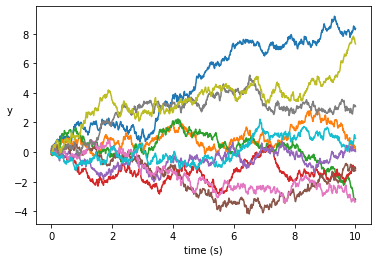

In [11]:
fBm = Fractional_Brownian_Simulator(0.5)
simulations_viewer(10, fBm)

In [1]:
# Find statistics of the sample path
# Check covariance (nutshell 1)
# Estimate the heurst parameter
# Compare the complexity of implementations